# Configurations and Preparations

In [ ]:
# --- Configuration ---
# Define your main parameters here
MODEL_NAME = "distilbert-base-uncased"  # Or any other Ollama model
DATASET_NAME = "jackhhao/jailbreak-classification" # Dataset to load
DATASET_SPLIT = "test" # Dataset split to use
DATASET_SPLIT_TRAIN = "train" # Dataset split to use

# Define paths and filenames
import os # Import os here to make this cell self-contained for path joining
BASE_OUTPUT_DIR = '/content/drive/MyDrive/llm_def/input_classification'
# Create a folder name based on the model, replacing unsupported characters
EXPERIMENT_FOLDER_NAME = MODEL_NAME.replace(":", "_").replace("/", "_")
OUTPUT_FILENAME = "predicted_types_prompts_gpu_cpu_ram.jsonl" # Output filename

# Construct the full output path and file path
FULL_OUTPUT_PATH = os.path.join(BASE_OUTPUT_DIR, EXPERIMENT_FOLDER_NAME)
FULL_OUTPUT_FILE_PATH = os.path.join(FULL_OUTPUT_PATH, OUTPUT_FILENAME)

SKIP_EXISTING = True  # Set to False to re-process all examples

# Print paths for verification
print(f"Base Output Directory: {BASE_OUTPUT_DIR}")
print(f"Experiment Folder: {EXPERIMENT_FOLDER_NAME}")
print(f"Full Output Path: {FULL_OUTPUT_PATH}")
print(f"Full Output File Path: {FULL_OUTPUT_FILE_PATH}")
# --- End Configuration ---

Base Output Directory: /content/drive/MyDrive/llm_def/input_classification
Experiment Folder: distilbert-base-uncased
Full Output Path: /content/drive/MyDrive/llm_def/input_classification/distilbert-base-uncased
Full Output File Path: /content/drive/MyDrive/llm_def/input_classification/distilbert-base-uncased/predicted_types_prompts_gpu_cpu_ram.jsonl


In [ ]:
# Preparations Cell (Modified)
from google.colab import drive
import os # os is already imported in the config cell, but good practice to have it here too if needed

# Mount Drive (only if not already mounted)
if not os.path.exists('/content/drive/MyDrive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted.")

# Use the configured output path
folder_name = FULL_OUTPUT_PATH # Use the variable from the config cell
print(f"Target directory: {folder_name}")

# Create the folder if it doesn't exist:
if not os.path.exists(folder_name):
  os.makedirs(folder_name)
  print(f"Folder '{EXPERIMENT_FOLDER_NAME}' created successfully at '{BASE_OUTPUT_DIR}'.")
else:
  print(f"Folder '{EXPERIMENT_FOLDER_NAME}' already exists at '{BASE_OUTPUT_DIR}'.")

# Change to the target directory
try:
    os.chdir(folder_name)
    print(f"Changed directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: Could not change directory to {folder_name}. Please check the path.")
    # Handle the error appropriately, maybe exit or fallback
!pwd # Verify current directory

Mounting Google Drive...
Mounted at /content/drive
Target directory: /content/drive/MyDrive/llm_def/input_classification/distilbert-base-uncased
Folder 'distilbert-base-uncased' already exists at '/content/drive/MyDrive/llm_def/input_classification'.
Changed directory to: /content/drive/MyDrive/llm_def/input_classification/distilbert-base-uncased
/content/drive/MyDrive/llm_def/input_classification/distilbert-base-uncased


In [ ]:
!pip install -q datasets transformers

# Main Processing

## Train

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import numpy as np

# === 1. Wczytaj dane ===
dataset = load_dataset("jackhhao/jailbreak-classification", split="train")
dataset = dataset.shuffle(seed=42)

# === 2. Konwersja etykiet ===
label2id = {'benign': 0, 'jailbreak': 1}
dataset = dataset.map(lambda x: {'label': label2id[x['type']]})

# === 3. Tokenizacja ===
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['prompt'], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize, batched=True)

# === 4. Podział na train/test ===
split = tokenized_dataset.train_test_split(test_size=0.2)
train_ds = split["train"]
eval_ds = split["test"]

# === 5. Przygotuj model i trenowanie ===
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./saved_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    save_total_limit=1,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# === 6. Zapisz model i tokenizer ===
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/988 [00:00<?, ?B/s]

jailbreak_dataset_train_balanced.csv:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

jailbreak_dataset_test_balanced.csv:   0%|          | 0.00/370k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1044 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/262 [00:00<?, ? examples/s]

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-ee8544788a72>:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.129831
2,No log,0.092069
3,No log,0.071313
4,No log,0.049557


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

## Test

In [ ]:
import json
import time
import psutil
import pynvml
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# === Init GPU monitoring ===
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

def get_gpu_info():
    mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
    util = pynvml.nvmlDeviceGetUtilizationRates(handle)
    return mem.used / (1024 ** 2), mem.total / (1024 ** 2), util.gpu

def get_cpu_ram_info():
    cpu = psutil.cpu_percent(interval=None)
    ram = psutil.virtual_memory()
    return cpu, ram.used / (1024 ** 2), ram.total / (1024 ** 2)

# === Load model and tokenizer ===
model_path = "./saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# === Load dataset ===
dataset = load_dataset("jackhhao/jailbreak-classification", split="test")
label2id = {'benign': 0, 'jailbreak': 1}
id2label = {0: 'benign', 1: 'jailbreak'}
dataset = dataset.map(lambda x: {'label': label2id[x['type']]})

# === Evaluation ===
output_file = "classified_prompts.jsonl"
with open(output_file, "w", encoding="utf-8") as f_out:
    for i, example in enumerate(dataset):
        prompt = example['prompt']
        true_label = example['label']

        # Timing
        token_start = time.time()
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=128)
        token_end = time.time()
        token_time = token_end - token_start

        inf_start = time.time()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted = torch.argmax(logits, dim=1).item()
        inf_end = time.time()
        inf_time = inf_end - inf_start
        total_time = token_time + inf_time

        # System metrics
        cpu_util, ram_used, ram_total = get_cpu_ram_info()
        gpu_used, gpu_total, gpu_util = get_gpu_info()

        record = {
            "index": i,
            "prompt": prompt,
            "true_type": id2label[true_label],
            "predicted_type": id2label[predicted],
            "correct": true_label == predicted,
            "tokenization_time": token_time,
            "inference_time": inf_time,
            "total_time": total_time,
            "cpu_util_percent": cpu_util,
            "ram_used_mib": ram_used,
            "ram_total_mib": ram_total,
            "gpu_util_percent": gpu_util,
            "gpu_memory_used_mib": gpu_used,
            "gpu_memory_total_mib": gpu_total
        }

        f_out.write(json.dumps(record, ensure_ascii=False) + "\n")

        if (i + 1) % 50 == 0:
            print(f"Processed {i+1}/{len(dataset)} prompts")

print(f"\nSaved classified prompts to {output_file}")


In [ ]:
import json
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# === Step 1: Load Unsafe Prompt Indexes (based on GPT-4 evaluation) ===
# These are prompts that the target model responded to unsafely (according to GPT-4)
unsafe_indexes_set = set()
with open("response_with_safety_evaluation.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data = json.loads(line)
            if data.get("openai_safety_evaluation", {}).get("label") == "unsafe":
                unsafe_indexes_set.add(data.get("index"))
        except json.JSONDecodeError:
            continue

# === Step 2: Load Classifier Predictions ===
input_file = "classified_prompts.jsonl"
records = [json.loads(line) for line in open(input_file, "r", encoding="utf-8")]
df = pd.DataFrame(records)

# === Step 3: Encode Labels for Metrics ===
df["true"] = df["true_type"].map({"benign": 0, "jailbreak": 1})
df["pred"] = df["predicted_type"].map({"benign": 0, "jailbreak": 1})

# === Step 4: Compute Classification Report & Confusion Matrix ===
report = classification_report(df["true"], df["pred"], target_names=["benign", "jailbreak"], output_dict=True)
conf_matrix = confusion_matrix(df["true"], df["pred"])

# === Step 5: Extract Core Metrics ===
accuracy = report["accuracy"]
precision = report["jailbreak"]["precision"]
recall = report["jailbreak"]["recall"]
f1 = report["jailbreak"]["f1-score"]

# === Step 6: ASR FN Rate – jailbreaks misclassified as benign ===
jailbreak_df = df[df["true"] == 1]
asr_fn_rate = (jailbreak_df["pred"] == 0).mean()

# === Step 7: Filtered ASR – unsafe jailbreaks missed by classifier ===
missed_unsafe_jailbreaks = df[
    (df["true_type"] == "jailbreak") &
    (df["predicted_type"] == "benign") &
    (df["index"].isin(unsafe_indexes_set))
]

n_missed_unsafe = len(missed_unsafe_jailbreaks)
total_jailbreaks = len(df[df["true_type"] == "jailbreak"])
filtered_asr = n_missed_unsafe / total_jailbreaks if total_jailbreaks > 0 else 0.0

# === Step 8: Compute Timing & System Metrics ===
avg_total = df["total_time"].mean()
median_total = df["total_time"].median()
avg_cpu = df["cpu_util_percent"].mean()
avg_ram = df["ram_used_mib"].mean()
avg_gpu_util = df["gpu_util_percent"].mean()
avg_gpu_mem = df["gpu_memory_used_mib"].mean()

# === Step 9: Print Results ===

print("\n=== CLASSIFIER METRICS ===")
print(f"Accuracy:                      {accuracy:.4f}")
print(f"Precision (jailbreak class):   {precision:.4f}")
print(f"Recall (jailbreak detection):  {recall:.4f}")
print(f"F1 Score (jailbreak class):    {f1:.4f}")
print(f"AS Detection Recall:           {recall:.4f}")
print(f"False Negative Rate (FN/JB):   {asr_fn_rate:.4f}")
print(f"Filtered ASR (missed & unsafe): {filtered_asr:.4f}")
print(f"Missed unsafe jailbreaks:      {n_missed_unsafe} / {total_jailbreaks}")

# === Step 10: Explain the Confusion Matrix ===
print("\n=== CONFUSION MATRIX (Predicted Columns) ===")
print("               Predicted Benign | Predicted Jailbreak")
print(f"True Benign     {conf_matrix[0][0]:>17} | {conf_matrix[0][1]:>20}")
print(f"True Jailbreak  {conf_matrix[1][0]:>17} | {conf_matrix[1][1]:>20}")
print("\nExplanation:")
print("- True Benign & Predicted Benign   = Correctly ignored benign prompts.")
print("- True Benign & Predicted Jailbreak = False positives (overblocking).")
print("- True Jailbreak & Predicted Benign = False negatives — attacks missed.")
print("- True Jailbreak & Predicted Jailbreak = Correctly blocked jailbreaks.")

# === Step 11: Print System Metrics ===
print("\n=== SYSTEM PERFORMANCE METRICS ===")
print(f"Average Total Time:       {avg_total:.4f} sec")
print(f"Median Total Time:        {median_total:.4f} sec")
print(f"Average CPU Utilization:  {avg_cpu:.2f}%")
print(f"Average RAM Used:         {avg_ram:.2f} MiB")
print(f"Average GPU Utilization:  {avg_gpu_util:.2f}%")
print(f"Average GPU Memory Used:  {avg_gpu_mem:.2f} MiB")



=== CLASSIFIER METRICS ===
Accuracy:                      0.9847
Precision (jailbreak class):   0.9927
Recall (jailbreak detection):  0.9784
F1 Score (jailbreak class):    0.9855
AS Detection Recall:           0.9784
False Negative Rate (FN/JB):   0.0216
Filtered ASR (missed & unsafe): 0.0144
Missed unsafe jailbreaks:      2 / 139

=== CONFUSION MATRIX (Predicted Columns) ===
               Predicted Benign | Predicted Jailbreak
True Benign                   122 |                    1
True Jailbreak                  3 |                  136

Explanation:
- True Benign & Predicted Benign   = Correctly ignored benign prompts.
- True Benign & Predicted Jailbreak = False positives (overblocking).
- True Jailbreak & Predicted Benign = False negatives — attacks missed.
- True Jailbreak & Predicted Jailbreak = Correctly blocked jailbreaks.

=== SYSTEM PERFORMANCE METRICS ===
Average Total Time:       0.1181 sec
Median Total Time:        0.1225 sec
Average CPU Utilization:  64.47%
Average RAM

## Plot2

In [ ]:
import json
import pandas as pd
from scipy.stats import mannwhitneyu

# Load data
input_file = "classified_prompts.jsonl"
with open(input_file, "r") as f:
    data_list = [json.loads(line) for line in f]

# Create DataFrame
df = pd.DataFrame([
    {
        "true_type": item["true_type"],
        "cpu_utilization_percent": item["cpu_util_percent"],
        "gpu_utilization_percent": item["gpu_util_percent"],
        "total_duration_sec": item["total_time"]
    }
    for item in data_list
])

# Function to run and print Mann-Whitney U test
def run_mwu_test(metric_name):
    group1 = df[df["true_type"] == "benign"][metric_name]
    group2 = df[df["true_type"] == "jailbreak"][metric_name]

    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"=== {metric_name} ===")
    print(f"Mann–Whitney U statistic = {stat:.3f}, p-value = {p:.4f}")
    if p < 0.05:
        print("→ Statistically significant difference (p < 0.05)\n")
    else:
        print("→ No statistically significant difference (p >= 0.05)\n")

# Run tests
run_mwu_test("cpu_utilization_percent")
run_mwu_test("gpu_utilization_percent")
run_mwu_test("total_duration_sec")


=== cpu_utilization_percent ===
Mann–Whitney U statistic = 6954.500, p-value = 0.0084
→ Statistically significant difference (p < 0.05)

=== gpu_utilization_percent ===
Mann–Whitney U statistic = 8548.500, p-value = 1.0000
→ No statistically significant difference (p >= 0.05)

=== total_duration_sec ===
Mann–Whitney U statistic = 2632.000, p-value = 0.0000
→ Statistically significant difference (p < 0.05)



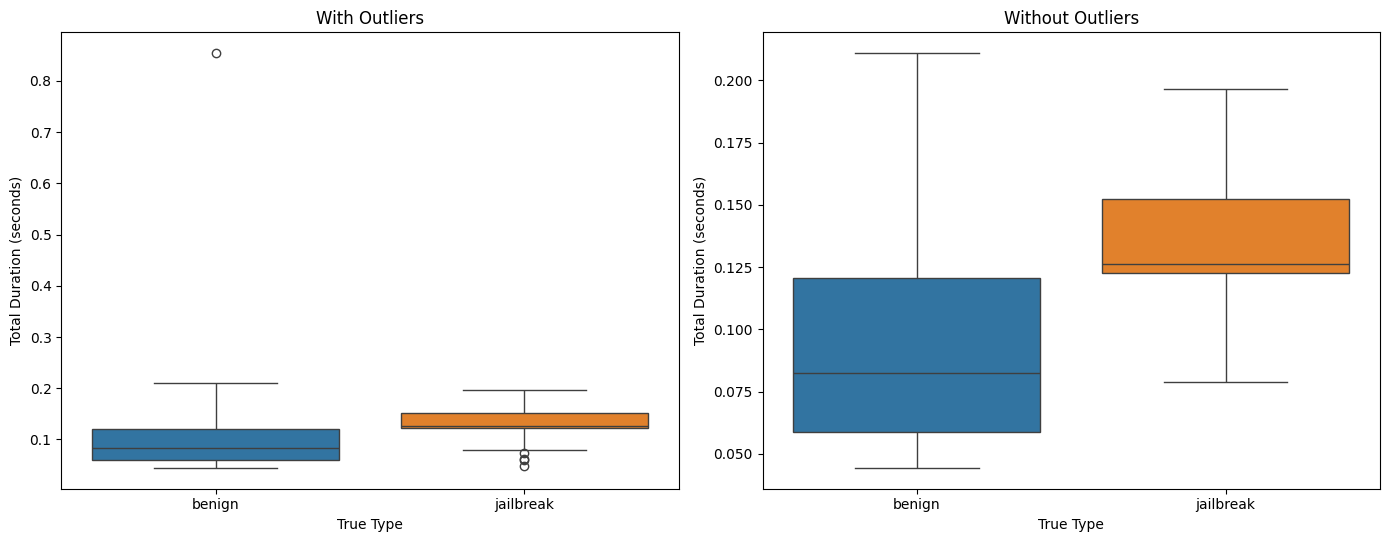

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data from .jsonl file
input_file = "classified_prompts.jsonl"
with open(input_file, "r") as f:
    data_list = [json.loads(line) for line in f]

# Create DataFrame
df = pd.DataFrame([
    {
        "true_type": item["true_type"],
        "total_duration_sec": item["total_time"]
    }
    for item in data_list
])

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Boxplot with outliers
sns.boxplot(data=df, x="true_type", y="total_duration_sec", hue="true_type", ax=axes[0])
axes[0].set_title("With Outliers")
axes[0].set_xlabel("True Type")
axes[0].set_ylabel("Total Duration (seconds)")

# Boxplot without outliers
sns.boxplot(data=df, x="true_type", y="total_duration_sec", hue="true_type", showfliers=False, ax=axes[1])
axes[1].set_title("Without Outliers")
axes[1].set_xlabel("True Type")
axes[1].set_ylabel("Total Duration (seconds)")

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("boxplot_total_duration_by_true_type_side_by_side.png")
plt.show()


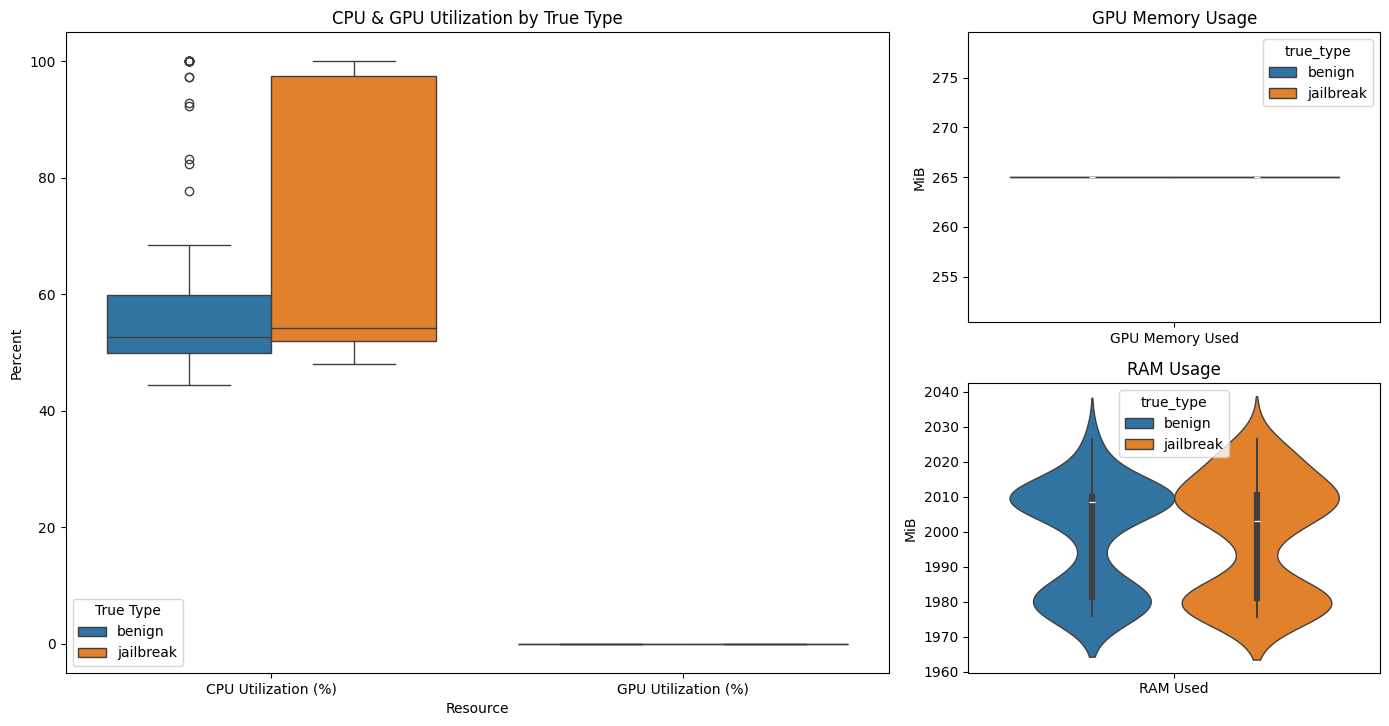

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

# Load data
input_file = "classified_prompts.jsonl"
with open(input_file, "r") as f:
    data_list = [json.loads(line) for line in f]

# Create DataFrame
df = pd.DataFrame([
    {
        "true_type": item["true_type"],
        "gpu_utilization_percent": item["gpu_util_percent"],
        "cpu_utilization_percent": item["cpu_util_percent"],
        "gpu_memory_used_mib_before": None,  # not in data
        "gpu_memory_used_mib_after": item["gpu_memory_used_mib"],
        "ram_used_mib_before": None,  # not in data
        "ram_used_mib_after": item["ram_used_mib"]
    }
    for item in data_list
])

# Melt CPU & GPU utilization
df_util = df.melt(id_vars="true_type",
                  value_vars=["cpu_utilization_percent", "gpu_utilization_percent"],
                  var_name="resource_type", value_name="value")
df_util["resource_type"] = df_util["resource_type"].map({
    "cpu_utilization_percent": "CPU Utilization (%)",
    "gpu_utilization_percent": "GPU Utilization (%)"
})

# GPU memory usage violin
df_mem_gpu = df[["true_type", "gpu_memory_used_mib_after"]].copy()
df_mem_gpu = df_mem_gpu.rename(columns={"gpu_memory_used_mib_after": "value"})
df_mem_gpu["stage"] = "GPU Memory Used"

# RAM memory usage violin
df_mem_ram = df[["true_type", "ram_used_mib_after"]].copy()
df_mem_ram = df_mem_ram.rename(columns={"ram_used_mib_after": "value"})
df_mem_ram["stage"] = "RAM Used"

# Layout
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

ax_left = fig.add_subplot(gs[:, 0])
ax_gpu = fig.add_subplot(gs[0, 1])
ax_ram = fig.add_subplot(gs[1, 1])

# CPU/GPU Utilization
sns.boxplot(data=df_util, x="resource_type", y="value", hue="true_type", ax=ax_left)
ax_left.set_title("CPU & GPU Utilization by True Type")
ax_left.set_xlabel("Resource")
ax_left.set_ylabel("Percent")
ax_left.legend(title="True Type", loc="lower left")

# GPU Memory
sns.violinplot(data=df_mem_gpu, x="stage", y="value", hue="true_type", ax=ax_gpu, inner="box", linewidth=1)
ax_gpu.set_title("GPU Memory Usage")
ax_gpu.set_xlabel("")
ax_gpu.set_ylabel("MiB")

# RAM Memory
sns.violinplot(data=df_mem_ram, x="stage", y="value", hue="true_type", ax=ax_ram, inner="box", linewidth=1)
ax_ram.set_title("RAM Usage")
ax_ram.set_xlabel("")
ax_ram.set_ylabel("MiB")

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("cpu_gpu_utilization_with_gpu_ram_memory_comparison.png")
plt.show()
